In [1]:
import torch, torchdata, torchtext
from torch import nn

import time

#1. puffer - it's outdated....
#2. spend some money - 300 baht get collab pro

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#reproducibility 
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


# 1. Loading Dataset

In [2]:
from torchtext.datasets import SST2

train = SST2(split='train')
test = SST2(split='dev')

#2. EDA

In [3]:
# let's take a look at one example of train
next(iter(train))

('hide new secretions from the parental units', 0)

In [4]:
# labels
set([y for x, y in list(iter(train))])

{0, 1}

In [5]:
train_size = len(list(iter(train)))
train_size

67349

In [6]:
train, val = train.random_split(total_length=train_size, 
                                            weights = {"train": 0.90, 
                                                       "val": 0.10},
                                            seed = SEED)

In [7]:
train_size = len(list(iter(train)))
val_size   = len(list(iter(val)))
test_size  = len(list(iter(test)))

In [8]:
train_size, val_size, test_size

(60614, 6735, 872)

# 3. Preprocessing

In [10]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_md')

In [11]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):  #data_iter, e.g., train
    for text, _  in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>',
                                                                 '<bos>', '<eos>'])

In [12]:
vocab.set_default_index(vocab["<unk>"]) 

In [13]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[235, 13, 6, 0, 6]

In [14]:
id2word = vocab.get_itos()

In [15]:
id2word[0], id2word[5]

('<unk>', ',')

In [16]:
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [17]:
len(vocab)

13844

# 4. FastTextEmbedding

In [18]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

.vector_cache/wiki.simple.vec: 293MB [00:09, 31.2MB/s]                           
100%|██████████| 111051/111051 [00:11<00:00, 9271.15it/s] 


In [19]:
fast_embedding.shape

torch.Size([13844, 300])

# 5. Preparing the Dataloader

In [20]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [23]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #making each batch same length

pad_ix = vocab['<pad>']

#this function gonna be called by DataLoader
def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_text, _label) in batch:
        label_list.append(label_pipeline(_label))  #[3, 1, 0, 2, ]
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64) #[0, 44, 21, 2]
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) #for padding
        
    return torch.tensor(label_list, dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_ix, batch_first=True), \
        torch.tensor(length_list, dtype=torch.int64)

In [24]:
batch_size = 64

train_loader = DataLoader(train, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

val_loader   = DataLoader(val, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

test_loader  = DataLoader(test, batch_size = batch_size,
                          shuffle=True, collate_fn=collate_batch)

In [25]:
for label, text, length in train_loader:
    print("Label shape:", label.shape)
    print("Text shape:", text.shape)
    print("Length shape:", length.shape)
    break

Label shape: torch.Size([64])
Text shape: torch.Size([64, 31])
Length shape: torch.Size([64])


# 6. Design the Model

In [26]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, 
                 dropout):
        super().__init__()
        #input dim = how many vocab you have
        #emb dim = 300 --> we use fasttext
        #padding_idx tells this lookup table to ignore, and just randomize....
        #<unk>, <bos>, <eos>
        self.embedding_layer = nn.Embedding(input_dim, emb_dim, padding_idx=pad_ix)
        self.lstm            = nn.LSTM(emb_dim,
                                       hid_dim,
                                       num_layers = num_layers,
                                       bidirectional = bidirectional,
                                       dropout = dropout,  #dropout is applied between layers....
                                       batch_first=True)
        
        self.fc              = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, x, lengths):
        #x: [batch size, seq len]
        
        embedded_x = self.embedding_layer(x)
        #x: [batch size, seq len, emb dim]
        
        #pack this embedded_x in such a way that RNN knows to ignore padding....
        #without batch_first = True; things will become [seq len, batch size, emb dim]
        pack_embedded = nn.utils.rnn.pack_padded_sequence(embedded_x, lengths.to('cpu'),
                                                          enforce_sorted=False,
                                                          batch_first = True
                                                          )
        
        #packed_outputs is basically all hidden states
        #h is the last hidden state
        #c is the last cell state
        packed_outputs, (h, _) = self.lstm(pack_embedded)
        
        #h: [num_layers * num_directions, batch_size, hidden dim]
        
        #it happens that because packed_outputs is all hidden states....some hidden states near the end is
        #hidden state for padding, pytorch guys help you
        #by using this pad_packed_sequence, then all the hidden states will only be not padding....
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first = True)
        #output: [batch size, seq len, direction * hidden sim]
        
        #last hidden state - concat last forward and backward states
        last_hidden_state = torch.cat((h[-1, :, :], h[-2, :, :]), dim = 1)
        #last_hidden_state: [batch_size, hidden_dim * 2]
        
        #for sentiment analysis.....what should i sent to my linear layer...
        return self.fc(last_hidden_state)  #[batch_size, output_dim]==> [batch_size, 4]
        

# 7. Training

In [27]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [28]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300
output_dim = 2 # two classes

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
model.embedding_layer.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [29]:
# we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

4153200
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  1024
     2
______
6873970


In [30]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [31]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [32]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [33]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

## Puttig everything together

In [34]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(val_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [35]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [36]:
best_valid_loss = float('inf')
num_epochs      = 10

save_path = f'{model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Time: 0m 19s
	Train Loss: 0.318 | Train Acc: 86.29%
	 Val. Loss: 0.158 |  Val. Acc: 94.41%
Epoch: 02 | Time: 0m 20s
	Train Loss: 0.163 | Train Acc: 93.88%
	 Val. Loss: 0.086 |  Val. Acc: 97.04%
Epoch: 03 | Time: 0m 18s
	Train Loss: 0.110 | Train Acc: 95.93%
	 Val. Loss: 0.063 |  Val. Acc: 97.77%
Epoch: 04 | Time: 0m 18s
	Train Loss: 0.080 | Train Acc: 97.00%
	 Val. Loss: 0.047 |  Val. Acc: 98.39%
Epoch: 05 | Time: 0m 19s
	Train Loss: 0.062 | Train Acc: 97.64%
	 Val. Loss: 0.035 |  Val. Acc: 98.76%
Epoch: 06 | Time: 0m 18s
	Train Loss: 0.050 | Train Acc: 98.04%
	 Val. Loss: 0.035 |  Val. Acc: 98.70%
Epoch: 07 | Time: 0m 18s
	Train Loss: 0.042 | Train Acc: 98.34%
	 Val. Loss: 0.024 |  Val. Acc: 99.12%
Epoch: 08 | Time: 0m 19s
	Train Loss: 0.034 | Train Acc: 98.64%
	 Val. Loss: 0.017 |  Val. Acc: 99.54%
Epoch: 09 | Time: 0m 18s
	Train Loss: 0.028 | Train Acc: 98.96%
	 Val. Loss: 0.016 |  Val. Acc: 99.41%
Epoch: 10 | Time: 0m 18s
	Train Loss: 0.023 | Train Acc: 99.09%
	 Val. Lo

Text(0.5, 1.0, 'Loss plot')

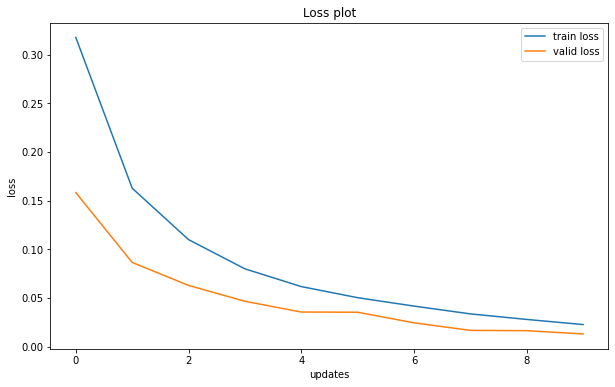

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
plt.title('Loss plot')

Text(0.5, 1.0, 'Accuracy plot')

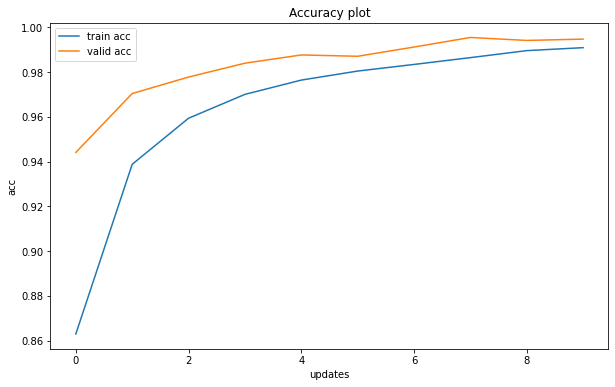

In [39]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')
plt.title('Accuracy plot')

In [40]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.294 | Test Acc: 79.58%


# 8. Test on some random news

In [41]:
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([   0,   13,  585, 4070, 4369,    9,    0,    0, 1521,   13,  117,   77,
         585,    9], device='cuda:0')

In [42]:
text_list = [x.item() for x in text]
text_list

[0, 13, 585, 4070, 4369, 9, 0, 0, 1521, 13, 117, 77, 585, 9]

In [43]:
text = text.reshape(1, -1)  #because batch_size is 1

In [44]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [45]:
text.shape

torch.Size([1, 14])

In [46]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [47]:
predict(text, text_length)

tensor([0], device='cuda:0')

# 9.1 Negative Negative Sentence Test

In [48]:

test_str = "Action was not bad."
text = torch.tensor(text_pipeline(test_str)).to(device)
text_list = [x.item() for x in text]
text = text.reshape(1, -1)  #because batch_size is 1
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [49]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [50]:
predict(text, text_length)

tensor([1], device='cuda:0')

In [51]:
test_str = "The actors didn't perform bad."
text = torch.tensor(text_pipeline(test_str)).to(device)
text_list = [x.item() for x in text]
text = text.reshape(1, -1)  #because batch_size is 1
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [52]:
predict(text, text_length)

tensor([1], device='cuda:0')

# 9.2 Negative Positive Sentence Test

In [53]:
test_str = "The actors didn't perform well."
text = torch.tensor(text_pipeline(test_str)).to(device)
text_list = [x.item() for x in text]
text = text.reshape(1, -1)  #because batch_size is 1
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [54]:
predict(text, text_length)

tensor([0], device='cuda:0')

# Overview

The model's accuracy is almost 100%. Although for the negative-negative sentence test the model predicted wrong for the 2nd example.